In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
import utils
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure

#Facebook Prophet
from prophet import Prophet
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_cross_validation_metric

/home/zenanahmed/.pyenv/versions/3.8.12/envs/Team_Energy/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


In [2]:
#!pip install utils

In [3]:
#utils.median_filter

In [20]:
wd=pd.read_csv('https://storage.googleapis.com/weather-data-processed-for-le-wagon/cleaned_weather_hourly_darksky.csv')
df=pd.read_csv('https://storage.googleapis.com/energy_consumption_903/df_all_avg_v3.csv')

In [21]:
wd=pd.read_csv('https://storage.googleapis.com/weather-data-processed-for-le-wagon/cleaned_weather_hourly_darksky.csv')
wd_filt=wd[['time','temperature','windSpeed','precipType_rain']]
wd_filt.rename(columns={'time':'DateTime'},inplace=True)


/tmp/ipykernel_23392/3157365981.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wd_filt.rename(columns={'time':'DateTime'},inplace=True)


In [6]:
df[['DateTime']].merge(wd_filt,on='DateTime',how='inner')

,DateTime,temperature,windSpeed,precipType_rain
0,2012-01-01 00:00:00,9.75,1.79,1.0
1,2012-01-01 00:00:00,9.75,1.79,1.0
2,2012-01-01 00:00:00,9.75,1.79,1.0
3,2012-01-01 00:00:00,9.75,1.79,1.0
4,2012-01-01 00:00:00,9.75,1.79,1.0
...,...,...,...,...
588013,2014-02-28 00:00:00,6.37,4.08,1.0
588014,2014-02-28 00:00:00,6.37,4.08,1.0
588015,2014-02-28 00:00:00,6.37,4.08,1.0
588016,2014-02-28 00:00:00,6.37,4.08,1.0


In [7]:
df.set_index('DateTime',inplace=True)

In [8]:
df5=df.loc[:,['Acorn_Group','KWH/hh']]
data_gla=df5.groupby(by=df5.index).mean()
data_gla

,KWH/hh
DateTime,
2012-01-01 00:00:00,0.231551
2012-01-01 00:30:00,0.249021
2012-01-01 01:00:00,0.230137
2012-01-01 01:30:00,0.222626
2012-01-01 02:00:00,0.228136
...,...
2014-02-27 22:00:00,0.343924
2014-02-27 22:30:00,0.335663
2014-02-27 23:00:00,0.269226


In [9]:
data_gla=data_gla.reset_index()
data_gla

,DateTime,KWH/hh
0,2012-01-01 00:00:00,0.231551
1,2012-01-01 00:30:00,0.249021
2,2012-01-01 01:00:00,0.230137
3,2012-01-01 01:30:00,0.222626
4,2012-01-01 02:00:00,0.228136
...,...,...
37868,2014-02-27 22:00:00,0.343924
37869,2014-02-27 22:30:00,0.335663
37870,2014-02-27 23:00:00,0.269226
37871,2014-02-27 23:30:00,0.236664


In [10]:
data_gla.rename(columns={"DateTime": "ds", "KWH/hh": "y"},inplace=True)
data_gla

,ds,y
0,2012-01-01 00:00:00,0.231551
1,2012-01-01 00:30:00,0.249021
2,2012-01-01 01:00:00,0.230137
3,2012-01-01 01:30:00,0.222626
4,2012-01-01 02:00:00,0.228136
...,...,...
37868,2014-02-27 22:00:00,0.343924
37869,2014-02-27 22:30:00,0.335663
37870,2014-02-27 23:00:00,0.269226
37871,2014-02-27 23:30:00,0.236664


In [11]:
##  UK bank holidays, took out Northern Ireland and Scotland as data is for London
holidays=pd.read_csv(os.path.join(os.getcwd(),'../raw_data/uk_bank_holidays.csv'))
holidays.rename(columns={'Type':'holiday','Bank holidays':'ds'},inplace=True)
holidays

,holiday,ds
0,Boxing Day,26/12/2012
1,Christmas Day,25/12/2012
2,Summer bank holiday,27/08/2012
3,Queen's Diamond Jubilee,06/05/2012
4,Spring bank holiday,06/04/2012
5,Early May bank holiday,05/07/2012
6,Easter Monday,04/09/2012
7,Good Friday,04/06/2012
8,New Year's Day,01/02/2012
9,Boxing Day,26/12/2013


In [ ]:
holidays.loc[:,'ds']=pd.to_datetime(holidays['ds'],format="%d/%m/%Y")

In [103]:
wd_filt.head()

,DateTime,temperature,windSpeed,precipType_rain
0,2011-11-11 00:00:00,10.24,2.77,1.0
1,2011-11-11 00:30:00,10.24,2.77,1.0
2,2011-11-11 01:00:00,9.76,2.95,1.0
3,2011-11-11 01:30:00,9.76,2.95,1.0
4,2011-11-11 02:00:00,9.46,3.17,1.0


In [77]:
temp = wd_filt['temperature'].interpolate(method='linear')
# wind = wd_filt['windSpeed'].interpolate(method='linear')
# rain = wd_filt['precipType_rain'].interpolate(method='linear')

data_gla_regressor=data_gla
data_gla_regressor['temp']=temp
data_gla_regressor

,ds,y,temp
0,2012-01-01 00:00:00,0.231551,10.24
1,2012-01-01 00:30:00,0.249021,10.24
2,2012-01-01 01:00:00,0.230137,9.76
3,2012-01-01 01:30:00,0.222626,9.76
4,2012-01-01 02:00:00,0.228136,9.46
...,...,...,...
37868,2014-02-27 22:00:00,0.343924,0.68
37869,2014-02-27 22:30:00,0.335663,0.68
37870,2014-02-27 23:00:00,0.269226,0.63
37871,2014-02-27 23:30:00,0.236664,0.63


In [20]:
m = Prophet(holidays=holidays,changepoint_prior_scale=0.01).add_regressor('temp', prior_scale=0.5, mode='multiplicative')
m.fit(data_gla_regressor)

11:11:28 - cmdstanpy - INFO - Chain [1] start processing
11:11:42 - cmdstanpy - INFO - Chain [1] done processing


In [89]:
future = m.make_future_dataframe(periods=2009, freq='30T')
wd_filt.loc[:,'DateTime']=pd.to_datetime(wd_filt['DateTime'])
wd_filt_future=future[['ds']].merge(wd_filt,left_on='ds',right_on='DateTime',how='inner').drop(columns='DateTime')
temp_future=wd_filt_future['temperature'].interpolate(method='linear')
future['temp']=temp_future
future

/tmp/ipykernel_6948/342844147.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wd_filt.loc[:,'DateTime']=pd.to_datetime(wd_filt['DateTime'])


,ds,temp
0,2012-01-01 00:00:00,9.75
1,2012-01-01 00:30:00,9.75
2,2012-01-01 01:00:00,9.68
3,2012-01-01 01:30:00,9.68
4,2012-01-01 02:00:00,9.63
...,...,...
39877,2014-04-10 18:30:00,6.47
39878,2014-04-10 19:00:00,5.96
39879,2014-04-10 19:30:00,5.96
39880,2014-04-10 20:00:00,5.38


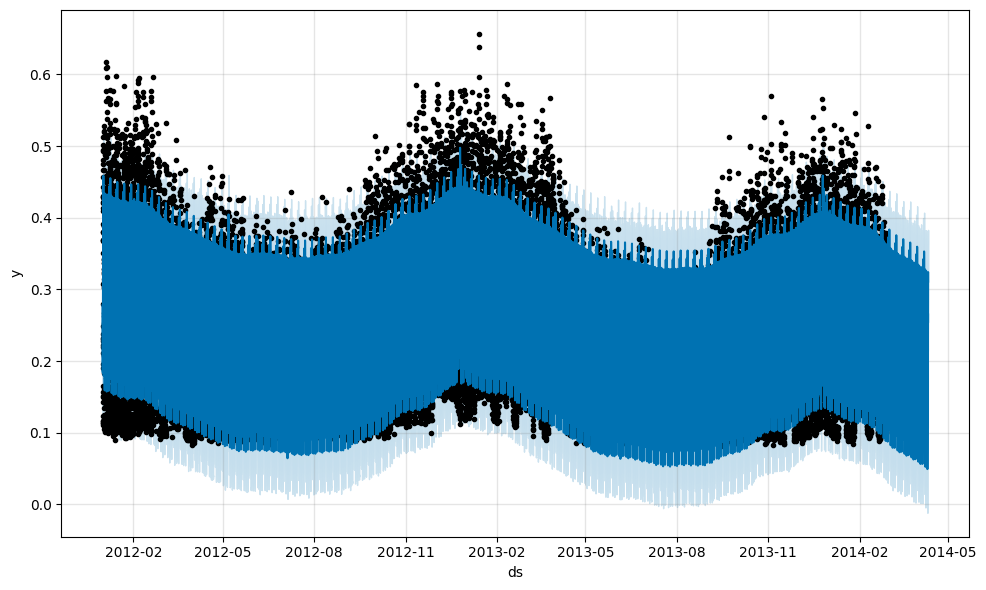

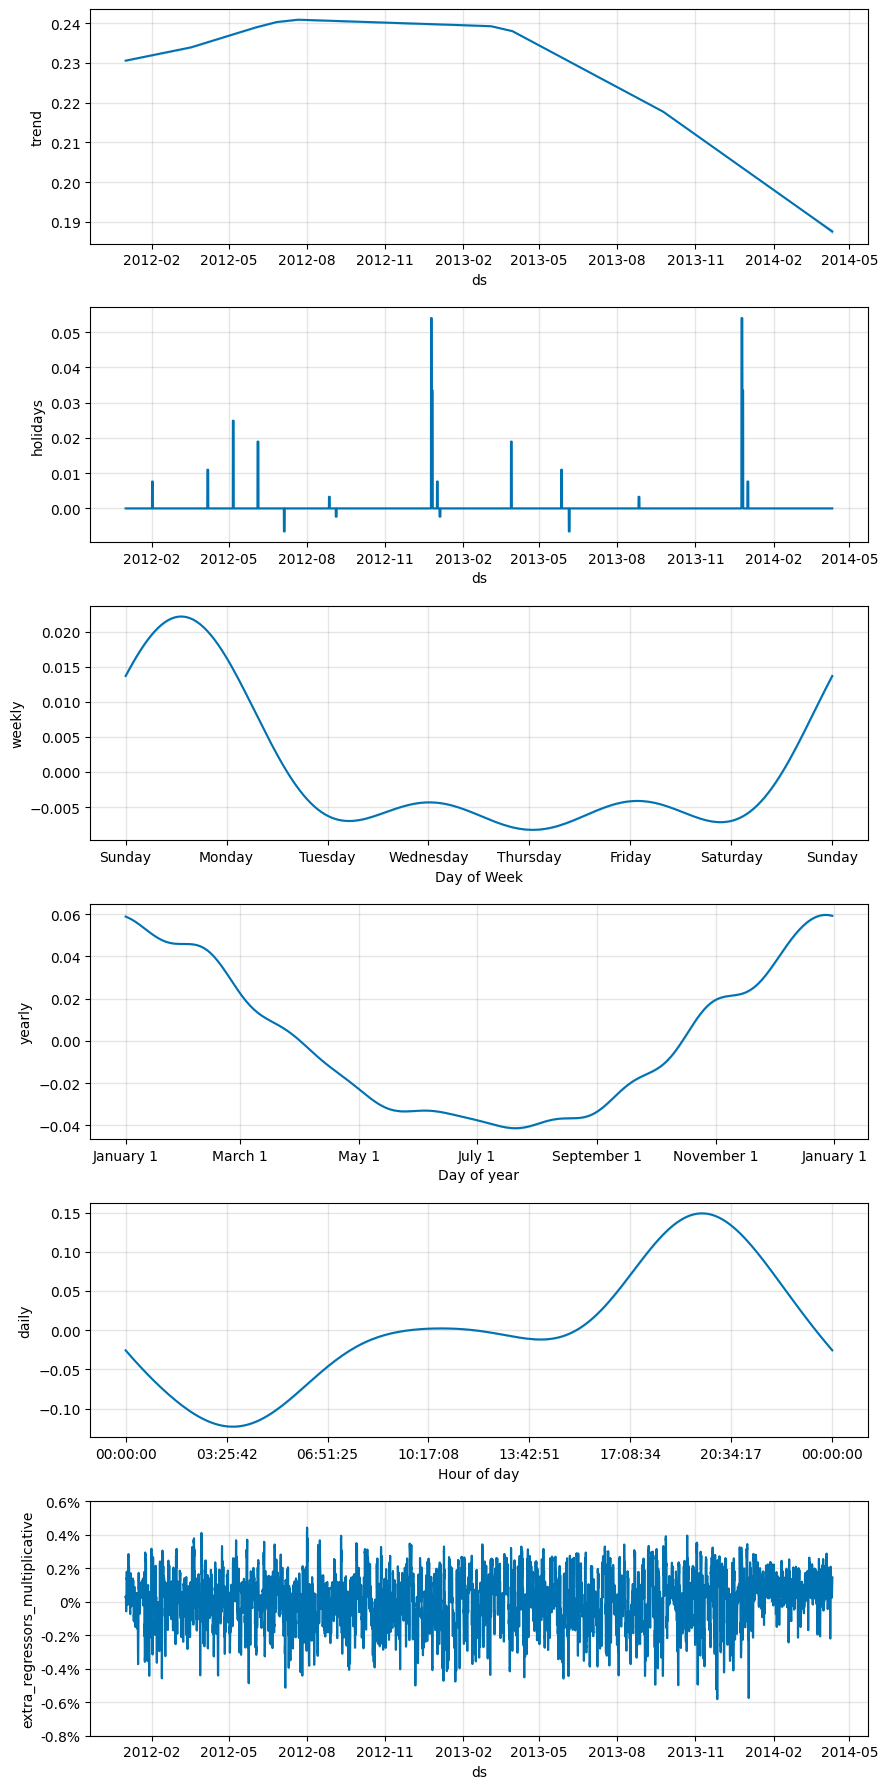

In [90]:
fcst = m.predict(future)
fig = m.plot(fcst)
fig = m.plot_components(fcst)

<AxesSubplot:xlabel='ds', ylabel='yhat'>

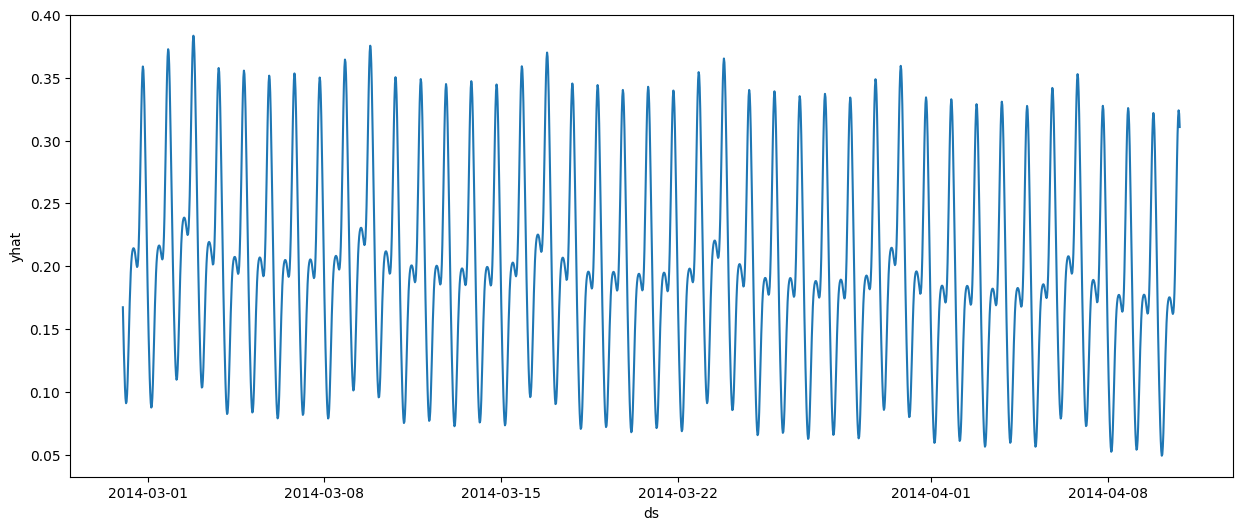

In [96]:
forecast=fcst.loc[fcst['ds']>'2014-02-28 00:00:00',['ds','yhat']]
actual=data_gla.loc[data_gla['ds']>'2014-02-28 00:00:00',['ds','y']]
figure(figsize=(15,6))
sns.lineplot(x=forecast['ds'],y=forecast['yhat'])
sns.lineplot(x=actual['ds'],y=actual['y'])

In [100]:
df_cv = cross_validation(m, initial='366 days', period='180 days', horizon = '90 days')

  0%|                                                                                             | 0/2 [00:00<?, ?it/s]11:49:17 - cmdstanpy - INFO - Chain [1] start processing
11:49:20 - cmdstanpy - INFO - Chain [1] done processing
 50%|██████████████████████████████████████████▌                                          | 1/2 [00:21<00:21, 21.15s/it]11:49:38 - cmdstanpy - INFO - Chain [1] start processing
11:49:45 - cmdstanpy - INFO - Chain [1] done processing
100%|█████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:45<00:00, 23.00s/it]


In [102]:
df_p = performance_metrics(df_cv)
df_p.head()

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,9 days 00:00:00,0.001465,0.038271,0.030067,0.165756,0.117050,0.153715,0.878472
1,9 days 00:30:00,0.001465,0.038272,0.030071,0.165755,0.117050,0.153728,0.878472
2,9 days 01:00:00,0.001467,0.038295,0.030120,0.166052,0.117354,0.154036,0.878472
3,9 days 01:30:00,0.001470,0.038342,0.030164,0.166374,0.117458,0.154281,0.878472
4,9 days 02:00:00,0.001476,0.038414,0.030239,0.167074,0.117780,0.154843,0.877315


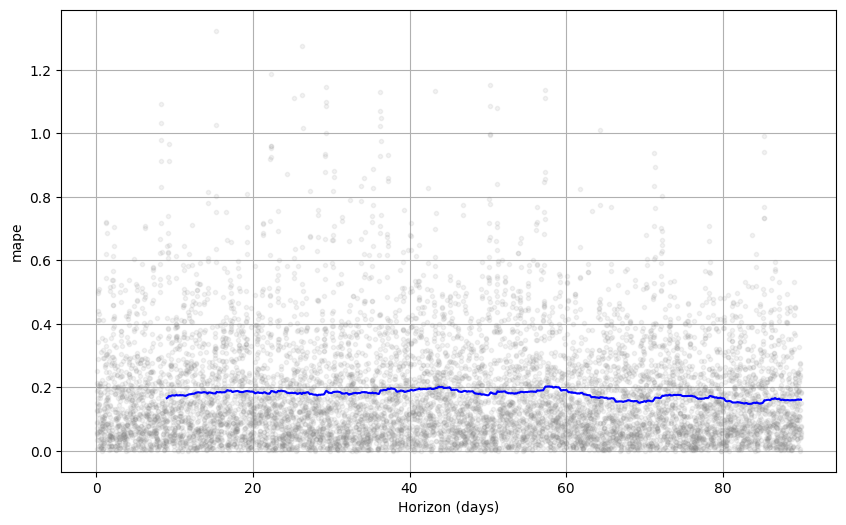

In [101]:
fig = plot_cross_validation_metric(df_cv, metric='mape')